pip install tqdm
pip install pillow
pip install image
pip install keras
pip install imblearn

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# Load data and preprocessing

In [2]:
train_dataset = pd.read_csv('../../plant-pathology-2020-fgvc7/train.csv')
test_dataset = pd.read_csv('../../plant-pathology-2020-fgvc7/test.csv')

In [3]:
print("-----------------------TRAIN-------------------------- \n :",train_dataset.head())
print("\n Shape : ",train_dataset.shape)

-----------------------TRAIN-------------------------- 
 :   image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0

 Shape :  (1821, 5)


In [4]:
print("-----------------------TEST-------------------------- \n :",test_dataset.head())
print("\n Shape : ",test_dataset.shape)

-----------------------TEST-------------------------- 
 :   image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

 Shape :  (1821, 1)


In [5]:
train_dataset.describe()

,healthy,multiple_diseases,rust,scab
count,1821.000000,1821.000000,1821.000000,1821.000000
mean,0.283361,0.049973,0.341571,0.325096
std,0.450754,0.217948,0.474367,0.468539
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


In [6]:
targets = train_dataset[['healthy', 'multiple_diseases', 'rust', 'scab']]

 Split the data into train and validation sets, then take a quick look at their make up.

In [7]:
train, validation = train_test_split(train_dataset, test_size=0.2)

Display a picture

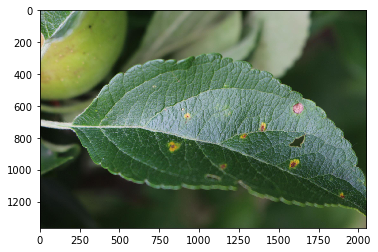

In [8]:
# Retour d'une image de façon aléatoire
randImg = np.random.randint(1820)
img = mpimg.imread(f'../../plant-pathology-2020-fgvc7/images/Train_{randImg}.jpg')
imgplot = plt.imshow(img)

On va stocker les images sous formes de données brutes au format LIB

In [9]:
from tqdm.notebook import tqdm
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

size = 64

nb_img = train_dataset.shape[0]
path = '../../plant-pathology-2020-fgvc7/images/'
train_images = np.ndarray(shape=(train_dataset.shape[0], size, size, 3))
test_images = np.ndarray(shape=(test_dataset.shape[0], size, size, 3))

# tqdm pour avoir une barre dévolution
for i in tqdm(range(nb_img)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  train_images[i] = np.float32(img_to_array(img))
    
for i in tqdm(range(nb_img)):
  img = load_img(path + f'Train_{i}.jpg', target_size=(size, size))
  test_images[i] = np.float32(img_to_array(img))

Using TensorFlow backend.


In [10]:
print("Train_images :",train_images.shape)
print("Test_images :",test_images.shape)

Train_images : (1821, 64, 64, 3)
Test_images : (1821, 64, 64, 3)


Réequilibre des images pour chaque dim

In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
x_res, y_res = ros.fit_resample(np.reshape(train_images, (-1, size * size * 3)), targets.to_numpy())
x_res = x_res.reshape((-1, size, size, 3))

Séparation des données

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2)

In [13]:
from tensorflow.keras.layers import * # Convolution2D, MaxPooling, Flatten, Dense
from tensorflow.keras.models import * # Sequential
from tensorflow.keras.regularizers import * # 
from tensorflow.keras.optimizers import * # 

Préparation des données avec un ImageDataGenerator

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1990, 64, 64, 3)
(1990, 4)
(498, 64, 64, 3)
(498, 4)


In [15]:
train_data = x_train.reshape((x_train.shape[0], size, size*3))
test_data = x_test.reshape((x_test.shape[0], size, size*3))

In [16]:
train_data.shape

(1990, 64, 192)

In [17]:
# New train_labels
train_labels = np.ndarray(shape=(train_data.shape[0], 1), dtype=int, order='F')
test_labels = np.ndarray(shape=(test_data.shape[0], 1), dtype=int, order='F')
i = 0
j = 0
while i<train_labels.shape[0]:
    train_labels.put(i,np.argmax(y_train[i]))
    i=i+1
while j<test_labels.shape[0]:
    test_labels.put(j,np.argmax(y_test[j]))
    j=j+1

In [18]:
train_data = train_data/255
test_data = test_data/255

## Modèle Linéaire

In [19]:
class Linear:

    def __init__(self):
        self.name = "lin"
        self.nb_hidden_layers = 0
        self.layers_size = []
        self.use_layers_activation = False
        self.layers_activation = 'relu'
        self.output_activation = 'softmax'
        self.loss = 'sparse_categorical_crossentropy'
        self.optimizer = 'Adam'
        self.metrics = ['sparse_categorical_accuracy']

In [20]:
def create_linModel(lin_struct: Linear):
    model = Sequential()
    model.add(Flatten(input_shape=(size, size, 3)))
    model.add(Dense(4, activation=lin_struct.output_activation))
    model.compile(loss=lin_struct.loss,
                  metrics=lin_struct.metrics)

    return model

In [21]:
#linStruct = Linear()
#linModel = create_linModel(struct)
#print(linModel.summary())

In [22]:
#linModel.fit(x_train, y_train,epochs=100,batch_size=)

In [23]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(1990, 64, 192)
(1990, 1)
(498, 64, 192)
(498, 1)


## Modèle RNN (Lstm)

Structure du LSTM

In [24]:
class Lstm:

    def __init__(self):
        self.nb_layers = 3
        self.units = 50
        self.activation = 'tanh'
        self.output_activation = 'softmax'
        self.recurrent_activation = 'sigmoid'
        self.dropout_value = 0.0
        self.kernel_regularizer = None
        self.recurrent_regularizer = None
        self.output_regularizer = None
        self.l1_value = 0.001
        self.l2_value = 0.0
        self.loss = 'sparse_categorical_crossentropy'
        self .optimizer = 'Adam'
        self.metrics = ['sparse_categorical_accuracy']

In [25]:
def create_lstm(lstm_struct: Lstm):

    input_tensor = Input((size, size*3))

    #Ici on va commencer à creer et empiler les différentes couches pour de meilleur prédictions
    lstm_tensor = input_tensor
    for i in range(lstm_struct.nb_layers - 1):
        lstm_tensor = LSTM(units= lstm_struct.units,
                           kernel_regularizer=lstm_struct.kernel_regularizer,
                           recurrent_regularizer=lstm_struct.recurrent_regularizer,
                           dropout=lstm_struct.dropout_value,
                           return_sequences=True
                           )(lstm_tensor)

    #Return_sequences prend False ici 
    lstm_tensor = LSTM(units=lstm_struct.units,
                       kernel_regularizer=lstm_struct.kernel_regularizer,
                       recurrent_regularizer=lstm_struct.recurrent_regularizer,
                       dropout=lstm_struct.dropout_value,
                       return_sequences=False
                       )(lstm_tensor)

    output_tensor = Dense(4, activation=lstm_struct.output_activation, kernel_regularizer=lstm_struct.output_regularizer)(lstm_tensor)

    model = Model(input_tensor, output_tensor)

    model.compile(loss=lstm_struct.loss, optimizer=lstm_struct.optimizer, metrics=lstm_struct.metrics)

    return model

In [26]:
struct = Lstm()
struct.nb_layers=4
struct.dropout_value = 0.6
model = create_lstm(struct)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 192)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 50)            48600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 4)                 204       
Total params: 109,404
Trainable params: 109,404
Non-trainable params: 0
_______________________________________________________

In [34]:
struct = Lstm()
struct.nb_layers=6
struct.dropout_value = 0.2
struct.l1_value = 0.0
struct.l2_value = 0.0
model = create_lstm(struct)
history = model.fit(train_data, 
          train_labels,
          validation_data=(test_data, test_labels),
          epochs=100,
          batch_size=100)

Train on 1990 samples, validate on 498 samples
Epoch 1/100
1990/1990 [==============================] - 15s 8ms/sample - loss: 1.3824 - sparse_categorical_accuracy: 0.2719 - val_loss: 1.3925 - val_sparse_categorical_accuracy: 0.2490
Epoch 2/100
1990/1990 [==============================] - 1s 405us/sample - loss: 1.3645 - sparse_categorical_accuracy: 0.3045 - val_loss: 1.4051 - val_sparse_categorical_accuracy: 0.2309
Epoch 3/100
1990/1990 [==============================] - 1s 399us/sample - loss: 1.3476 - sparse_categorical_accuracy: 0.3291 - val_loss: 1.3896 - val_sparse_categorical_accuracy: 0.2791
Epoch 4/100
1990/1990 [==============================] - 1s 394us/sample - loss: 1.3325 - sparse_categorical_accuracy: 0.3322 - val_loss: 1.3265 - val_sparse_categorical_accuracy: 0.3735
Epoch 5/100
1990/1990 [==============================] - 1s 394us/sample - loss: 1.3120 - sparse_categorical_accuracy: 0.3578 - val_loss: 1.3055 - val_sparse_categorical_accuracy: 0.3735
Epoch 6/100
1990/19

1990/1990 [==============================] - 1s 394us/sample - loss: 0.6733 - sparse_categorical_accuracy: 0.7050 - val_loss: 0.9831 - val_sparse_categorical_accuracy: 0.5743
Epoch 45/100
1990/1990 [==============================] - 1s 400us/sample - loss: 0.6553 - sparse_categorical_accuracy: 0.7151 - val_loss: 1.1122 - val_sparse_categorical_accuracy: 0.5562
Epoch 46/100
1990/1990 [==============================] - 1s 399us/sample - loss: 0.6617 - sparse_categorical_accuracy: 0.7241 - val_loss: 1.0271 - val_sparse_categorical_accuracy: 0.5803
Epoch 47/100
1990/1990 [==============================] - 1s 396us/sample - loss: 0.6257 - sparse_categorical_accuracy: 0.7357 - val_loss: 0.9462 - val_sparse_categorical_accuracy: 0.5944
Epoch 48/100
1990/1990 [==============================] - 1s 393us/sample - loss: 0.6461 - sparse_categorical_accuracy: 0.7302 - val_loss: 1.1831 - val_sparse_categorical_accuracy: 0.5683
Epoch 49/100
1990/1990 [==============================] - 1s 398us/sample

Epoch 88/100
1990/1990 [==============================] - 1s 399us/sample - loss: 0.2852 - sparse_categorical_accuracy: 0.8970 - val_loss: 1.2274 - val_sparse_categorical_accuracy: 0.6285
Epoch 89/100
1990/1990 [==============================] - 1s 398us/sample - loss: 0.3178 - sparse_categorical_accuracy: 0.8819 - val_loss: 1.2671 - val_sparse_categorical_accuracy: 0.6165
Epoch 90/100
1990/1990 [==============================] - 1s 400us/sample - loss: 0.2956 - sparse_categorical_accuracy: 0.8864 - val_loss: 1.3320 - val_sparse_categorical_accuracy: 0.6185
Epoch 91/100
1990/1990 [==============================] - 1s 393us/sample - loss: 0.2880 - sparse_categorical_accuracy: 0.8935 - val_loss: 1.2777 - val_sparse_categorical_accuracy: 0.6205
Epoch 92/100
1990/1990 [==============================] - 1s 394us/sample - loss: 0.2379 - sparse_categorical_accuracy: 0.9090 - val_loss: 1.4335 - val_sparse_categorical_accuracy: 0.6024
Epoch 93/100
1990/1990 [==============================] - 1s

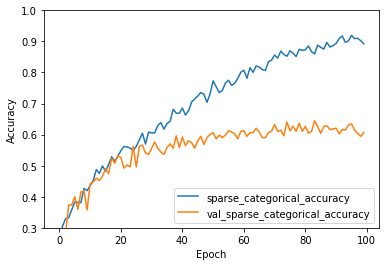

In [35]:
plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.3, 1])
plt.legend(loc='lower right')

In [29]:
from keras_preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255,
	    rotation_range=40,
      zoom_range=0.2,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(
    x = x_train, 
    y = y_train,
    batch_size = 32
    )

validation_generator = validation_datagen.flow(
    x = x_test,
    y = y_test,
    batch_size = 32
    )

## Modèle CNN

Premier test avec un model qui contient deux couches de conv(32,64) et Sorti(128) ==> accuracy: 0.2432 - val_accuracy: 0.2771

Deuxieme test avec un model qui contient trois couches de convolution (32,64,128) et Sorti(128-256) ==> accuracy: 0.2482 - val_accuracy: 0.2570

Troisième test avec un model qui contient quatres couches de convolution (32,64,128,256) et Sorti(128-256) ==>

Quatrième test avec un model qui contient cinqs couches de convolution (32,64,128,256,512) et Sorti(128-256) ==>

In [30]:
"""
def create_cnn():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape=(size, size, 3), activation='relu')),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),
    model.add(Dropout(0.4)),
    
    model.add(Conv2D(64, (3,3), activation='relu')),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),
    model.add(Dropout(0.4)),
    
    model.add(Conv2D(128, (3,3), activation='relu')),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),
    model.add(Dropout(0.4)),
    
    model.add(Conv2D(256, (3,3), activation='relu')),
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),
    model.add(Dropout(0.6)),
    
    model.add(Flatten()),
    model.add(Dropout(0.4)),
    
    model.add(Dense(256, activation='relu')),
    model.add(Dense(4, activation='softmax'))
    
    model.compile(loss = 'kullback_leibler_divergence', 
        optimizer = 'Adam', 
        metrics = ['accuracy'])
    
    return model
    
"""

"\ndef create_cnn():\n    model = Sequential()\n    model.add(Conv2D(32, (3,3), input_shape=(size, size, 3), activation='relu')),\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),\n    model.add(Dropout(0.4)),\n    \n    model.add(Conv2D(64, (3,3), activation='relu')),\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),\n    model.add(Dropout(0.4)),\n    \n    model.add(Conv2D(128, (3,3), activation='relu')),\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),\n    model.add(Dropout(0.4)),\n    \n    model.add(Conv2D(256, (3,3), activation='relu')),\n    model.add(BatchNormalization())\n    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2))),\n    model.add(Dropout(0.6)),\n    \n    model.add(Flatten()),\n    model.add(Dropout(0.4)),\n    \n    model.add(Dense(256, activation='relu')),\n    model.add(Dense(4, activation='softmax'))\n    \n  

In [31]:
"""
model_cnn = create_cnn()
model_cnn.fit(x_train, 
          y_train,
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=400)
          
"""

'\nmodel_cnn = create_cnn()\nmodel_cnn.fit(x_train, \n          y_train,\n          validation_data=(x_test, y_test),\n          epochs=100,\n          batch_size=400)\n          \n'

## Fonction de test de model